# Recommendation system using Collaborative filtering
---

## Introduction

Collaborative Filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. You can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

In this example, we will use collaborative filtering techniques to build a recommendation system for the table given below. The table contains users and the ratings that they have provided for certain books. The ratings are on a scale of 1-10.
<br >
<br >
![Book rating data](../data/table.png)
<br >

In [108]:
import pandas as pd
import numpy as np
from scipy import spatial
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

Lets import the data from `data.csv` file.

In [18]:
# import data
ratings = pd.read_csv('../data/data.csv')

# convert all rows to float
ratings[["Start With Why", "Superman", "Rebecca"]] = ratings[["Start With Why", "Superman", "Rebecca"]].astype(np.float64)

ratings

,Name,Harry Potter,Start With Why,Tom Sawyer,Superman,Rebecca,Hamlet
0,John,5.0,7.0,6.0,7.0,5.0,6.0
1,Jeff,5.0,7.0,3.0,9.0,7.0,6.0
2,Andrei,7.0,7.0,6.0,8.0,5.0,9.0
3,Mike,6.0,8.0,4.0,6.0,4.0,6.0
4,Mark,6.0,8.0,9.0,9.0,7.0,6.0
5,Jason,NaN,9.0,NaN,7.0,5.0,NaN


Lets take 2 books and plot all users that have rated these books. Users who have submitted similar ratings will lie closer to each other.

In [66]:
ratings[['Name', 'Start With Why', 'Superman']]

,Name,Start With Why,Superman
0,John,7.0,7.0
1,Jeff,7.0,9.0
2,Andrei,7.0,8.0
3,Mike,8.0,6.0
4,Mark,8.0,9.0
5,Jason,9.0,7.0


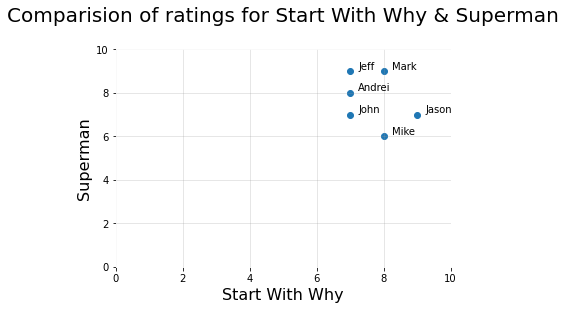

In [68]:
fig, ax = plt.subplots()
book1 = ratings["Start With Why"]
book2 = ratings["Superman"]
ax.scatter(book1, book2)

ax.set_ylabel('Superman', fontsize=16)
ax.set_xlabel('Start With Why', fontsize=16)
ax.set_title('Comparision of ratings for Start With Why & Superman', fontsize=20, y=1.1)

plt.xlim(0,10)
plt.ylim(0,10)
plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.3)

for i, txt in enumerate(ratings["Name"]):
    ax.annotate(txt, (book1[i], book2[i]),
                xytext=(8,2),
                textcoords='offset pixels')

## Similarity index using Euclidean distance

Looking at the plot, we can tell Jason may have preferences that are more similar to that of Mike than compared to Jeff and Andrei. We will use the Euclidean distance formula to calculate the similarity score between each user which will help determine users who have the most similar preference compared to Jason.


![Similarity using Euclidean distance](../data/euclidean.png)

<br />

*Goal: generate recommendations for a Jason*

*Steps:*
1. search a **large group of people** and **find a smaller set of similar people** with tastes **similar** to the **Jason**.
2. look at other things that the similar people like and combine them to create a **ranked list of recommendation** for the **Jason**

Lets calculate the similarity score for Jason with every other user, using the common books which they have rated

In [75]:
common_books = ratings[ratings.columns[~ratings.isnull().any()]]
common_books

,Name,Start With Why,Superman,Rebecca
0,John,7.0,7.0,5.0
1,Jeff,7.0,9.0,7.0
2,Andrei,7.0,8.0,5.0
3,Mike,8.0,6.0,4.0
4,Mark,8.0,9.0,7.0
5,Jason,9.0,7.0,5.0


In [101]:
spatial.distance.euclidean(john,jason_ratings)

2.0

In [105]:
jason_ratings = common_books.iloc[5][['Start With Why', 'Superman', 'Rebecca']].to_numpy()

In [129]:
similarity = []
for i in range(6):
    dist = spatial.distance.euclidean(common_books.iloc[i][['Start With Why', 'Superman', 'Rebecca']].to_numpy(),
                               jason_ratings)
    similarity.append(dist)
similarity = [1/(1+score) for score in similarity]
common_books['Similarity'] = similarity

In [130]:
common_books

,Name,Start With Why,Superman,Rebecca,Similarity
0,John,7.0,7.0,5.0,0.333333
1,Jeff,7.0,9.0,7.0,0.224009
2,Andrei,7.0,8.0,5.0,0.309017
3,Mike,8.0,6.0,4.0,0.366025
4,Mark,8.0,9.0,7.0,0.250000
5,Jason,9.0,7.0,5.0,1.000000


To predict ratings for books not rated by Jason:

1. Take all the ratings given by other users and multiply them by the respective similarity scores and add them all up
2. To get the final prediction divide the above sum (total) by the sum of all similarity values (similarity sum) of the users who rated that movie

In [131]:
unrated_books = ratings[ratings.columns[ratings.isnull().any()]]
unrated_books.insert(0, 'Name', ratings['Name'])
unrated_books.insert(4, 'Similarity', common_books['Similarity'])
unrated_books

,Name,Harry Potter,Tom Sawyer,Hamlet,Similarity
0,John,5.0,6.0,6.0,0.333333
1,Jeff,5.0,3.0,6.0,0.224009
2,Andrei,7.0,6.0,9.0,0.309017
3,Mike,6.0,4.0,6.0,0.366025
4,Mark,6.0,9.0,6.0,0.250000
5,Jason,NaN,NaN,NaN,1.000000


In [132]:
unrated_books['similarity_harrypotter'] = unrated_books['Harry Potter'] * unrated_books['Similarity']
unrated_books['similarity_tom'] = unrated_books['Tom Sawyer'] * unrated_books['Similarity']
unrated_books['similarity_hamlet'] = unrated_books['Hamlet'] * unrated_books['Similarity']

unrated_books

,Name,Harry Potter,Tom Sawyer,Hamlet,Similarity,similarity_harrypotter,similarity_tom,similarity_hamlet
0,John,5.0,6.0,6.0,0.333333,1.666667,2.000000,2.000000
1,Jeff,5.0,3.0,6.0,0.224009,1.120046,0.672028,1.344055
2,Andrei,7.0,6.0,9.0,0.309017,2.163119,1.854102,2.781153
3,Mike,6.0,4.0,6.0,0.366025,2.196152,1.464102,2.196152
4,Mark,6.0,9.0,6.0,0.250000,1.500000,2.250000,1.500000
5,Jason,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


In [141]:
sum_similarity = unrated_books['Similarity'][:-1].sum()

sum_harrypotter = unrated_books['similarity_harrypotter'][:-1].sum()
sum_tomsawyer = unrated_books['similarity_tom'][:-1].sum()
sum_hamlet = unrated_books['similarity_hamlet'][:-1].sum()

print(f"Sum of Similarity score:\t {sum_similarity}\n")
print(f"Total Harry Potter similarity:\t {sum_harrypotter}")
print(f"Total Tom Sawyer similarity:\t {sum_tomsawyer}")
print(f"Total Hamlet similarity:\t {sum_hamlet}")

Sum of Similarity score:	 1.4823849692325153

Total Harry Potter similarity:	 8.64598423869691
Total Tom Sawyer similarity:	 8.240231294606826
Total Hamlet similarity:	 9.821360798519933


In [145]:
potter_rating = sum_harrypotter/sum_similarity
sawyer_rating = sum_tomsawyer/sum_similarity
hamlet_rating = sum_hamlet/sum_similarity

print("\t\tJason's predicted ratings\n")
print(f"Harry Potter rating:\t {potter_rating}")
print(f"Tom Sawyer rating:\t {sawyer_rating}")
print(f"Hamlet rating:\t\t {hamlet_rating}")

		Jason's predicted ratings

Harry Potter rating:	 5.832482397047813
Tom Sawyer rating:	 5.558766086837141
Hamlet rating:		 6.625378024174658


After obtaining the predictive ratings for books that Jason hasn't read yet, we can recommend books based on these predictions. The method of allocating prediction can differ depending on the rules set by the recommender system. 

## Pearson Correlation Coefficient

Lets repeat the same process by using the Pearson Correlation Coefficient to calculate the similarity index between users. The formula for calculating the pearson correlation coefficient is as follows.

![Pearson correlation coefficient formula](../data/pearson.png)
<br >

In [146]:
# pearson correlation coefficient
def pearson(x,y):
    a = sum((x-np.mean(x))*(y-np.mean(y)))
    b = pow(sum(pow(x-np.mean(x),2)),0.5)*pow(sum(pow(y-np.mean(y),2)),0.5)
    return a/b

In [153]:
# Get the common items again
common_books = ratings[ratings.columns[~ratings.isnull().any()]]
common_books

,Name,Start With Why,Superman,Rebecca
0,John,7.0,7.0,5.0
1,Jeff,7.0,9.0,7.0
2,Andrei,7.0,8.0,5.0
3,Mike,8.0,6.0,4.0
4,Mark,8.0,9.0,7.0
5,Jason,9.0,7.0,5.0


In [155]:
similarity = []
jason_ratings = common_books.iloc[5][['Start With Why', 'Superman', 'Rebecca']].to_numpy()
for i in range(6):
    coef = pearson(common_books.iloc[i][['Start With Why', 'Superman', 'Rebecca']].to_numpy(),
                               jason_ratings)
    similarity.append(coef)
common_books['Similarity'] = similarity

common_books

,Name,Start With Why,Superman,Rebecca,Similarity
0,John,7.0,7.0,5.0,0.866025
1,Jeff,7.0,9.0,7.0,0.000000
2,Andrei,7.0,8.0,5.0,0.654654
3,Mike,8.0,6.0,4.0,1.000000
4,Mark,8.0,9.0,7.0,0.500000
5,Jason,9.0,7.0,5.0,1.000000


In [158]:
# Create dataframe of unrated books along with pearson similarity scores
unrated_books = ratings[ratings.columns[ratings.isnull().any()]]
unrated_books.insert(0, 'Name', ratings['Name'])
unrated_books.insert(4, 'Similarity', common_books['Similarity'])

# Calculate the total similarity for each book
unrated_books['similarity_harrypotter'] = unrated_books['Harry Potter'] * unrated_books['Similarity']
unrated_books['similarity_tom'] = unrated_books['Tom Sawyer'] * unrated_books['Similarity']
unrated_books['similarity_hamlet'] = unrated_books['Hamlet'] * unrated_books['Similarity']

# Find sum of similarity score
sum_similarity = unrated_books['Similarity'][:-1].sum()

# Find sum of total similarity scores
sum_harrypotter = unrated_books['similarity_harrypotter'][:-1].sum()
sum_tomsawyer = unrated_books['similarity_tom'][:-1].sum()
sum_hamlet = unrated_books['similarity_hamlet'][:-1].sum()

# Display sum and total similarity scores
print(f"Sum of Similarity score:\t {sum_similarity}\n")
print(f"Total Harry Potter similarity:\t {sum_harrypotter}")
print(f"Total Tom Sawyer similarity:\t {sum_tomsawyer}")
print(f"Total Hamlet similarity:\t {sum_hamlet}")

# Calculate predicted ratings for Jason
potter_rating = sum_harrypotter/sum_similarity
sawyer_rating = sum_tomsawyer/sum_similarity
hamlet_rating = sum_hamlet/sum_similarity

# Display ratings
print("\n\t\tJason's predicted ratings\n")
print(f"Harry Potter rating:\t {potter_rating}")
print(f"Tom Sawyer rating:\t {sawyer_rating}")
print(f"Hamlet rating:\t\t {hamlet_rating}")

Sum of Similarity score:	 3.0206790744924152

Total Harry Potter similarity:	 17.91270271387803
Total Tom Sawyer similarity:	 17.624074446954495
Total Hamlet similarity:	 20.088035459078426

		Jason's predicted ratings

Harry Potter rating:	 5.930025094402993
Tom Sawyer rating:	 5.834474306051855
Hamlet rating:		 6.650172018837835


## Conclusion

The predicted ratings obtained by using Pearson correlation coefficient is not too different from the ratings obtained from euclidean distance similarity scores. The order of ratings are exactly the same in both scenario with Hamlet receiving the highest rating and Tom Sawyer receiving the lowest rating.

We have implemented two techniques for building a recommendation system: using Euclidean distance and Pearson correlation coefficient. However, both these methods rely on prior knowledge of the user. This condition imposes major drawbacks in scenarios where enough relevant data are not available for analysis. It is suggested to use an ensemble fo algorithms to build a more comprehensive machine learning model such as combining content-based filtering with memory-based filtering. 